# MAC0460 / MAC5832 (2020)
<hr>

## EP4: Logistic regression

### Topics / concepts explored in this EP:

- Implementation of the **logistic regression algorithm**, using the gradient descent technique
- Application on binary classification of images, using their feature representation
- Confusion matrix, effects of unbalanced classes

Complete and submit this notebook. **PLEASE do no change the file name.**

### Evaluation  
- Correctitude of the algorithms
- Code
    - do not change the prototype of the functions
    - efficiency (you should avoid unnecessary loops; use matrix/vector computation with NumPy wherever appropriate)
    - cleanliness (do not leave any commented code or useless variables)
- Appropriateness of the answers
- File format: Complete and submit this notebook <font color="red">with the outputs of the execution</font>. **Do no change the file name.**
<hr>

### Hints
- It might be wise to first make sure your implementation is correct. For instance, you can compare the results of your implementation and of the one implemented in <a href="https://scikit-learn.org/stable/">scikit-learn</a>. After you feel confident, paste your code in the notebook, and then run the rest of the code in the notebook.
- If you face difficulties with Keras or other libraries used in this notebook, as well as clarity issues in the exercises in this notebook, post a message in the <a href="https://edisciplinas.usp.br/mod/forum/view.php?id=2785513">Forum for discussions</a>.

# 1. Logistic regression 

Here we use the formulation described in the book [2].

The cost function to be minimized is
$$
E_{in}(\mathbf{w}) = \frac{1}{N} \sum_{i=1}^{N} \ln(1 + e^{-y^{(i)} \mathbf{w}^T \mathbf{x}^{(i)}}) \tag{1}
$$

Its gradient is given by

$$\nabla E_{in}(\mathbf{w}) = - \frac{1}{N}\sum_{i=1}^{N} \frac{y^{(i)} \mathbf{x}^{(i)}}{1 + e^{y^{(i)} \mathbf{w}^T \mathbf{x}^{(i)}}}  \tag{2}$$

The logistic (sigmoid) function is
$$\sigma(z) = \frac{1}{1 + e^{-z}}  \tag{3}$$

### <font style="background-color: #ffff66;">Exercise 1</font>
<font style="background-color: #ffff66;">In the next three code cells, write the code to implement four functions that will be used below for logistic regression training and prediction. Use vectorial computation with NumPy.</font>

### Cross-entropy loss and cross-entropy gradient
The two functions in the following cell should implement, respectively, equations (1) and (2) above. 

In [1]:
import numpy as np

def cross_entropy(w, X, y):
    """
    Computes the loss (equation 1)
    :param w: weight vector
    :type: np.ndarray(shape=(1+d, 1))
    :param X: design matrix
    :type X: np.ndarray(shape=(N, 1+d))
    :param y: class labels
    :type y: np.ndarray(shape=(N, 1))
    :return loss: loss (equation 1)
    :rtype: float
    """    
    
    wTX = X.dot(w.T)
    # (N, 1) = (N, 1+d) . (1+d, 1)

    ywTX = (y*wTX)
    # (N, 1) = (N, 1) * (N, 1)

    exp = np.exp(-ywTX)
    err = np.log(1+exp)

    Ein = err.mean()
    #Ein = np.log(1+np.exp(-yr*Xe.dot(w.T))).mean()
    
    return Ein
    

def cross_entropy_gradient(w, X, y):
    """
    Computes the gradient of the loss function (equation 2)
    :param w: weight vector
    :type: np.ndarray(shape=(1+d, 1))
    :param X: design matrix
    :type X: np.ndarray(shape=(N, 1+d))
    :param y: class labels
    :type y: np.ndarray(shape=(N, 1))
    :return grad: gradient (equation 2)
    :rtype: float
    """    
    
    wTX = X.dot(w.T)
    # (N, 1) = (N, 1+d) . (1+d, 1)

    ywTX = (y*wTX)
    # (N, 1) = (N, 1) * (N, 1)
    
    den = 1 + np.exp(ywTX)
    
    num = y * X
    # (N, 1+d) = (N, 1) . (N, 1+d)
    
    div = num / den
    # (N, 1+d) = (N, 1+d) / (N, 1)

    grad = -div.mean(axis=0).T
    #grad = -( (yr * X) / (1+np.exp(yr*X.dot(w.T))) ).mean(axis=0).T
    
    return grad


### Logistic regression training

The function below receives the data matrix <tt>X (shape = (N, d))</tt> and the ouput vector <tt>y (shape = (N,))</tt>, and should return the final weight vector <tt>w</tt> and, optionally (when 
parameter <tt>return_history = True</tt>), a list of size <tt>num_iterations+1</tt> with the cross-entropy loss values at the beginning and after each of the iterations.

Note that the data matrix needs to be extended with a column of 1's.

In [19]:
def train_logistic(X, y, learning_rate = 1e-1, w0 = None,\
                        num_iterations = 1000, return_history = False):
    """
    Computes the weight vector applying the gradient descent technique
    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param y: class label
    :type y: np.ndarray(shape=(N, 1))
    :return: weight vector
    :rtype: np.ndarray(shape=(1+d, 1))
    :return: the history of loss values (optional)
    :rtype: list of float
    """    
     
    # Add into X a new column with 1s
    Xe = np.append(np.ones([len(X),1]),X,1)
    
    # Reshape
    yr = y.reshape(len(y), 1)
    
    if w0:
        w_current = w0.T
    else: 
        d = X.ndim
        w_current = np.ones([1, d+1])

    cost_history = np.zeros(num_iterations+1)
    cost_history[0] = cross_entropy(w_current, Xe, yr)
    
    for i in range(1, num_iterations+1): 
        grad = cross_entropy_gradient(w_current, Xe, yr)
        w_current = w_current - learning_rate*grad
        cost_history[i] = cross_entropy(w_current, Xe, yr)
    
    if return_history:
        return w_current[0,:], cost_history
    else:
        return w_current[0,:]


### Logistic regression prediction
The function in the next cell will be used to do the prediction of logistic regression. Recall that the prediction is a score in $[0,1]$, given by the sigmoid value of the linear combination.

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def predict_logistic(X, w):
    """
    Computes the logistic regression prediction
    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param w: weight vector
    :rtype: np.ndarray(shape=(1+d, 1))
    :return: predicted classes 
    :rtype: np.ndarray(shape=(N, ))
    """  
   
    # Add into X a new column with 1s
    N = len(X)
    Xe = np.append(np.ones([N,1]),X,1)

    z = Xe.dot(w.T)
    # (N, 1) = (N, 1+d) . (1+d, 1)
    
    theta = sigmoid(z).reshape(N,)
    
    return theta



# 2. MNIST Dataset #

This is a well known dataset, commonly used as a first example of image classification tasks. We could say it is the "Hello world!" of image classification. It consists of handwritten digits, divided into $60000$ training images and $10000$ test images. All images are gray-scale (one channel with pixel intensities varying from 0 to 255) and have size $28 \times 28$. There are 10 classes, corresponding to digits 0 to 9.

The dataset is available in many places. Here we will use the one available   with Keras [1]. 
More information on MNIST can be found at the [oficial site](http://yann.lecun.com/exdb/mnist/).

[1]: François Chollet and others, Keras, https://keras.io, 2015

In [4]:
from tensorflow.keras.datasets import mnist

(X_train_all, y_train_all), (X_test_all, y_test_all) = mnist.load_data()

print(X_train_all.shape, y_train_all.shape)
print(X_test_all.shape, y_test_all.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


### Class distribution of MNIST (training set)


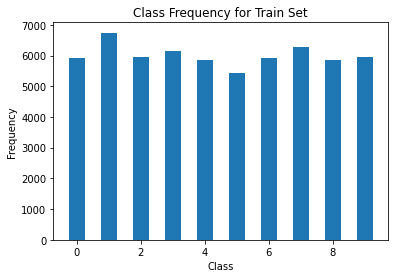

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

unique, counts = np.unique(y_train_all, return_counts=True)
plt.bar(unique, counts, 0.5)
plt.title('Class Frequency for Train Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### <font style="background-color: #ffff66;">Exercise 2</font>
<font style="background-color: #ffff66;">Repeat **Class distribution of MNIST** for the testing set (next cell) and compare and comment about the distributions of the training and of the testing sets. Do you think this type of comparison is important? Comment.</font>

It is important to see the difference in distribution of the sets. In order to generalize properly, trainning set has to be a good representation of the testing set. Otherwise, when we validate by testing, we can face problems with accurracy.

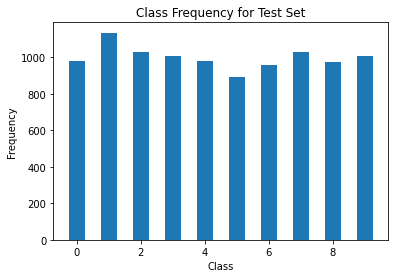

In [29]:
unique, counts = np.unique(y_test_all, return_counts=True)
plt.bar(unique, counts, 0.5)
plt.title('Class Frequency for Test Set')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### Visualization of some of the examples

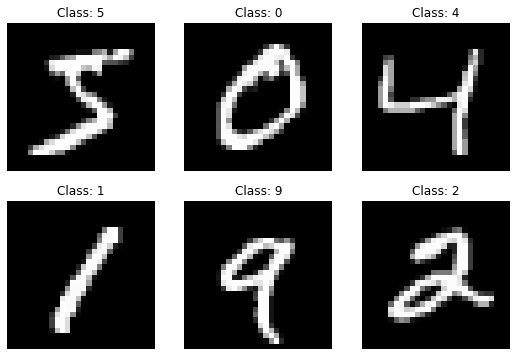

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train_all[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_all[i])
    
plt.show()

# 3. Feature extraction

Note that the images consist of 28×28=784 pixel values and they could be used as "raw features" of the images. However, here we will extract some features from the images and perform classification using them instead of the pixel values.

### Mean intensity

In the book _Learning from Data_ [2], one of the attributes (features) used by the authors is the mean intensity of pixel values. This feature is directly related to the proportion of the pixels corresponding to the digit in the image. For instance, it is reasonable to expect that a digit 5 or 2 occupies more pixels than the digit 1 and, therefore, the mean intensity of the first two should be larger than that of the digit 1.

### Symmetry

The second attribute used by the authors is horizontal symmetry.

Symmetry will be defined in terms of asymetry. We define asymmetry as the pixelwise mean of the absolute difference between the pixels values from the original image and those from the corresponding horizotally flipped image. Then, symmetry is defined as the negative of asymmetry.

[2]: Yaser S Abu-Mostafa, Malik Magdon-Ismail, and Hsuan-Tien Lin, Learning from Data, 2012

In [10]:
import numpy as np

def mean_intensity(image):
    return np.mean(image)

def Hsimmetry(image):
    # The processing below invert the order of the columns of the image
    reflected_image = image[:, ::-1]
    return -np.mean(np.abs(image - reflected_image))

## Pixels $\rightarrow$ Features ##

The above functions for feature extraction will be applied to the samples, both on the training and the test sets. After the feature extraction process below, each image will be represented by two features.

### <font style="background-color: #ffff66;">Exercise 3</font>

<font style="background-color: #ffff66;">Fill in the appropriate places in the two code cells below as indicated, to print the mean value of each feature in the training and test sets. Compare the mean values on training and test sets after normalization and comment on them.</font>


After the normalization process, the train set has its features wth mean at 0 and std dev at 1. We apply the same normalization with test set so we can maintain the comparability between samples from an interval scaling point of view.

In [11]:
import numpy as np

# Function that converts an image into a list of features,
# using the feature computation functions defined above
def convert2features(image):
    return np.array([mean_intensity(image),
                     Hsimmetry(image)])

# feature names
F = ['Mean intensity', 'Hsimmetry']

# Generate the feature representation for all images
X_train_features = np.array([convert2features(image) for image in X_train_all])
X_test_features  = np.array([convert2features(image) for image in X_test_all])

print(X_train_features.shape)
print(X_test_features.shape)

print("Mean for Train Set = ", X_train_features.mean(axis=0))
print("Mean for Test Set = ", X_test_features.mean(axis=0))

(60000, 2)
(10000, 2)
Mean for Train Set =  [ 33.31842145 -32.61779592]
Mean for Test Set =  [ 33.79122449 -32.45322449]


**Normalization** of feature values is a common procedure. Here we apply the z-score formula. Note that the normalization parameters (mean and standard deviation) are computed only on training data. To normalize the test data, we use the same parameters.
(We suggest you to think why we should not compute the mean and standard deviation over the training+test set. There is no need to answer this here.)

In [12]:
# Adjust the scale of feature values; standardize them.
# (Yes, the features in the test set should be standardized using
#  the statistics of the features in the training set) -- why ??
for i in range(X_train_features.shape[1]):
    avg = np.mean(X_train_features[:, i])
    stddev = np.std(X_train_features[:, i])
    X_train_features[:, i] = (X_train_features[:, i] - avg) / stddev
    X_test_features[:, i] = (X_test_features[:, i] - avg) / stddev

print(X_train_features.shape)
print(X_test_features.shape)

print("Training set, after normalization:", X_train_features.mean(axis=0))
print("Testing set, after normalization:", X_test_features.mean(axis=0))

(60000, 2)
(10000, 2)
Training set, after normalization: [-9.32624348e-17 -6.15603864e-16]
Testing set, after normalization: [0.04282203 0.02059222]


# 4. Logistic regression training and testing

## 4.1 Select a subset from two of the classes

Here we select two classes as well as a subset of the examples in each class. All code from here on will use the selected subset. You may change later the selected classes and the number of samples in each class.

### Select two classes

In [20]:
import numpy as np

P = 5  # positive class
N = 1  # negative class

X_train_P = X_train_features[y_train_all == P]
X_train_N = X_train_features[y_train_all == N]
y_train_P = y_train_all[y_train_all == P]
y_train_N = y_train_all[y_train_all == N]

X_test_P = X_test_features[y_test_all == P]
X_test_N = X_test_features[y_test_all == N]
y_test_P = y_test_all[y_test_all == P]
y_test_N = y_test_all[y_test_all == N]

print("Positive class: ", X_train_P.shape, y_train_P.shape)
print("Negative class: ", X_train_N.shape, y_train_N.shape)

Positive class:  (5421, 2) (5421,)
Negative class:  (6742, 2) (6742,)


### Select a subset of examples from each of the two classes

### <font style="background-color: #ffff66;">Exercise 4</font>
<font style="background-color: #ffff66;">In the following cell, write the code to change the label of the positive class to +1 and of the negative class to -1. </font>

In [56]:
# Number of positives and negatives to be effectively considered
# in the training data to be explored in the remainder of this notebook
nP = 100
nN = 100

X_train = np.concatenate([X_train_P[:nP], X_train_N[:nN]], axis = 0)
y_train = np.concatenate([y_train_P[:nP], y_train_N[:nN]], axis = 0).astype('float32')

X_test = np.concatenate([X_test_P, X_test_N], axis = 0)
y_test = np.concatenate([y_test_P, y_test_N], axis = 0).astype('float32')


# Change positive class label to +1 and negative class label to -1
y_train = np.where(y_train==1, -1, y_train) 
y_train = np.where(y_train==5, 1, y_train) 

y_test = np.where(y_test==1, -1, y_test) 
y_test = np.where(y_test==5, 1, y_test) 

# Shuffle
np.random.seed(56789)
def shuffle(X, y):
    # input and output must be shuffled equally
    perm = np.random.permutation(len(X))
    return X[perm], y[perm]

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(200, 2) (200,)
(2027, 2) (2027,)


### Plot the selected data

Let us plot the selected subset of data. Negative examples will be plotted in red and positive ones in blue.

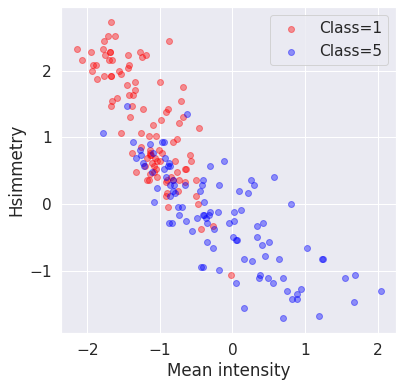

In [57]:
def plot_features(ax,X,y):
    # negatives in red
    ax.scatter(X[y==-1,0], \
               X[y==-1,1], \
               label='Class=%d'%N, c = 'red', alpha = 0.4)

    # and positives in blue
    ax.scatter(x=X[y==1,0], \
               y=X[y==1,1], \
               label='Class=%d'%P, c = 'blue', alpha = 0.4)

    ax.set_xlabel(F[0])
    ax.set_ylabel(F[1])
    ax.legend(loc='best')
    
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plot_features(ax,X_train,y_train)
plt.show()      


## 4.2 Training

### <font style="background-color: #ffff66;">Exercise 5</font>
<font style="background-color: #ffff66;">Run the code in the following cell a few times, each time with different values for  the learning rate and the number of iterations. Comment the behavior of the loss curve. Which values do you consider as good choices?

**Note:** for your submission, keep the execution output corresponding to the best parameter values you have found.</font>
 
With num_iterations = 100000, the learning_rate that shows convergence seems to be at most in 1e-3 magnitude. Increase num_iterations does not produce significant improvement with Final loss value. Thus, with this initial Final loss value, it is possible to lower learning_rate in order to get faster convergence. With num_iterations = 1000, we can lower learning_rate = 1e-1 and it converges to almost the same Acurracy of 0.386... than the previous case. 


Final weight:
 [ 1.8655747   1.42899373 -1.58145125]
Final loss:
 0.3866215245021722


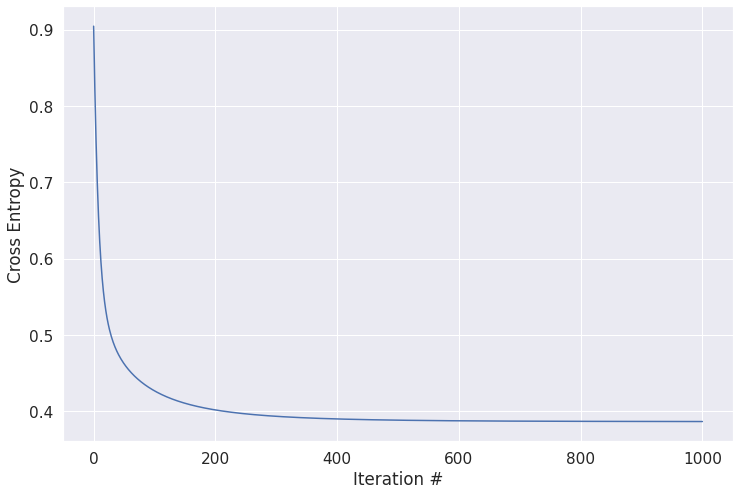

In [64]:

np.random.seed(56789)
w_logistic, loss = train_logistic(X_train, y_train,\
                                       learning_rate = 1e-1,
                                       num_iterations = 1000,\
                                       return_history = True)

print("Final weight:\n", w_logistic)
print("Final loss:\n", loss[-1])

plt.figure(figsize = (12, 8))
plt.plot(loss)
plt.xlabel('Iteration #')
plt.ylabel('Cross Entropy')
plt.show()

### Ploting the scores and decision boundary

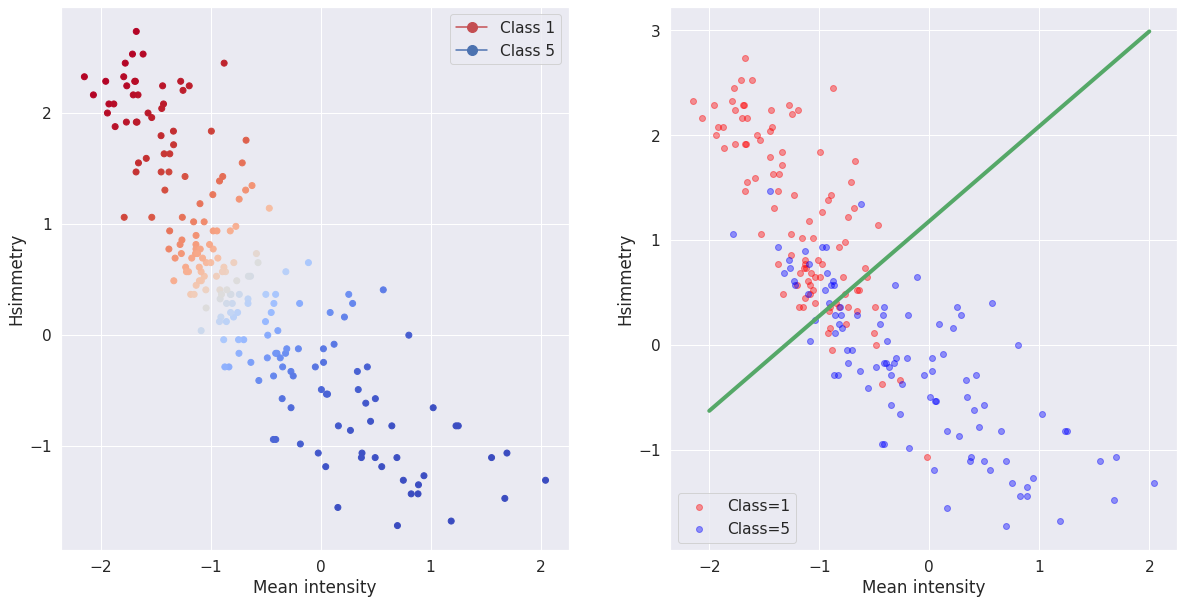

In [59]:
from matplotlib.lines import Line2D

y_pred = predict_logistic(X_train, w_logistic)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)

ax1.scatter(x = X_train[:,0], y = X_train[:,1],\
            c = -y_pred, cmap = 'coolwarm')
legend_elements = [Line2D([0], [0], marker='o', color='r',\
                    label='Class %d'%N, markerfacecolor='r',\
                    markersize=10),\
Line2D([0], [0], marker='o', color='b',\
                    label='Class %d'%P, markerfacecolor='b',\
                    markersize=10)]
ax1.set_xlabel(F[0])
ax1.set_ylabel(F[1])
ax1.legend(handles=legend_elements, loc='best')
      
ax2 = fig.add_subplot(122)
plot_features(ax2,X_train,y_train)

p1 = (-2, -(w_logistic[0] - 2*w_logistic[1])/w_logistic[2])
p2 = (2,  -(w_logistic[0] + 2*w_logistic[1])/w_logistic[2])

lines = ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], '-')
plt.setp(lines, color='g', linewidth=4.0)

plt.show()
        

### Confusion matrix

Recall that the logistic regression returns a score $\hat{p}$ in $[0,1]$, which can be interpreted as the probability $p(y=1|\mathbf{x})$. To compute the confusion matrix, one needs to choose a threshold value $T$ to decide the final class label (that is  $\hat{y} = 1 \Longleftrightarrow \hat{p} \geq T$ ).

In [60]:
import seaborn as sn
import pandas as pd

def plot_confusion_matrix(y, y_pred):
    """
    It receives an array with the ground-truth (y)
    and another with the prediction (y_pred), both with binary labels
    (positve=+1 and negative=-1) and plots the confusion
    matrix.
    It uses P (positive class id) and N (negative class id)
    which are "global" variables ...
    """
    TP = np.sum((y_pred == 1) * (y == 1))
    TN = np.sum((y_pred == -1) * (y == -1))

    FP = np.sum((y_pred == 1) * (y == -1))
    FN = np.sum((y_pred == -1) * (y == 1))

    total = TP+FP+TN+FN
    print("TP = %4d    FP = %4d\nFN = %4d    TN = %4d"%(TP,FP,FN,TN))
    print("Accuracy = %d / %d (%f)\n" %((TP+TN),total, (TP+TN)/total))
    confusion = [
        [TP/(TP+FN), FP/(TN+FP)],
        [FN/(TP+FN), TN/(TN+FP)]
    ]

    df_cm = pd.DataFrame(confusion, \
                         ['$\hat{y} = %d$'%P, '$\hat{y} = %d$'%N],\
                         ['$y = %d$'%P, '$y = %d$'%N])
    plt.figure(figsize = (8,4))
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, annot=True)
    plt.show()
    

### <font style="background-color: #ffff66;">Exercise 6</font>
<font style="background-color: #ffff66;">Play with the threshold value in the code (following cell). Did you manage to find a threshold value (other than 0.5) that improves accuracy? How threshold relates to TP, FP, TN and FN ? Comment.</font>

It is possible to analyse the best threshold with a search. It was found, as shown below, that the best acurracy was at threshold = 0.530758, with acurracy = 0.835.

Best threshold =  0.530758


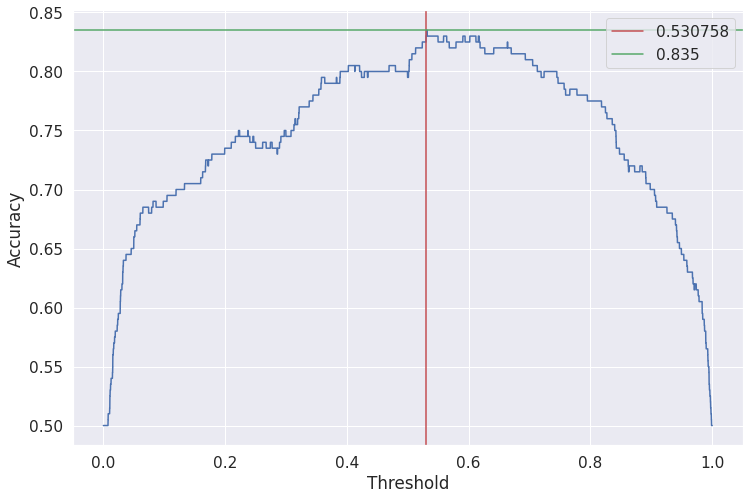

TP =   79    FP =   12
FN =   21    TN =   88
Accuracy = 167 / 200 (0.835000)



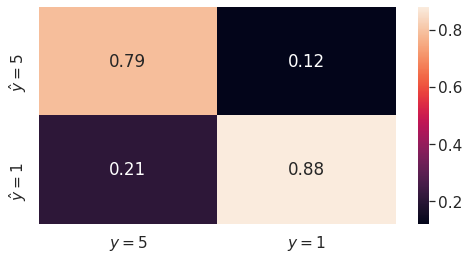

In [65]:
import seaborn as sn
import pandas as pd

samples = 1000000
accuracy = np.zeros(samples)

for i in range(0, samples): 
    
    threshold = i/samples
    
    p_hat = predict_logistic(X_train, w_logistic)
    y_hat = np.where(p_hat >= threshold, 1, -1)
    
    total = len(y_hat)
    TP = np.sum((y_hat == 1) * (y_train == 1))
    TN = np.sum((y_hat == -1) * (y_train == -1))
    FP = np.sum((y_hat == 1) * (y_train == -1))
    FN = np.sum((y_hat == -1) * (y_train == 1))
    accuracy[i] = ((TP+TN)/(TP+FP+TN+FN))
    
best = np.argmax(accuracy)/samples
print("Best threshold = ", best)

plt.figure(figsize = (12, 8))
plt.plot(np.arange(0, 1, 1/samples), accuracy)
plt.axvline(x=best, c = 'r', label = best)
plt.axhline(y=max(accuracy), c = 'g', label = max(accuracy))
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

p_hat = predict_logistic(X_train, w_logistic)
y_hat = np.where(p_hat >= best, 1, -1)
plot_confusion_matrix(y_train, y_hat)

## 4.3 Testing

### <font style="background-color: #ffff66;">Exercise 7</font>
<font style="background-color: #ffff66;">Repeat score and boundary ploting, as well as confusion matrix ploting with respect to test set. Comment what you observed.</font>

We can see clearly that the low number of training samples did not disturbed with the accurracy much. It was 0.881598 for the test set, while for the train was 0.835. We may have better results if using more data to test. There is also the difference between the Accuracy. Data splitting is unreliable unless the total sample size is huge, i.e., we cannot guarantee that the splitted set is a good representation of the whole set. This can leads a model to different performes on distinct datasets of the single phenomena.

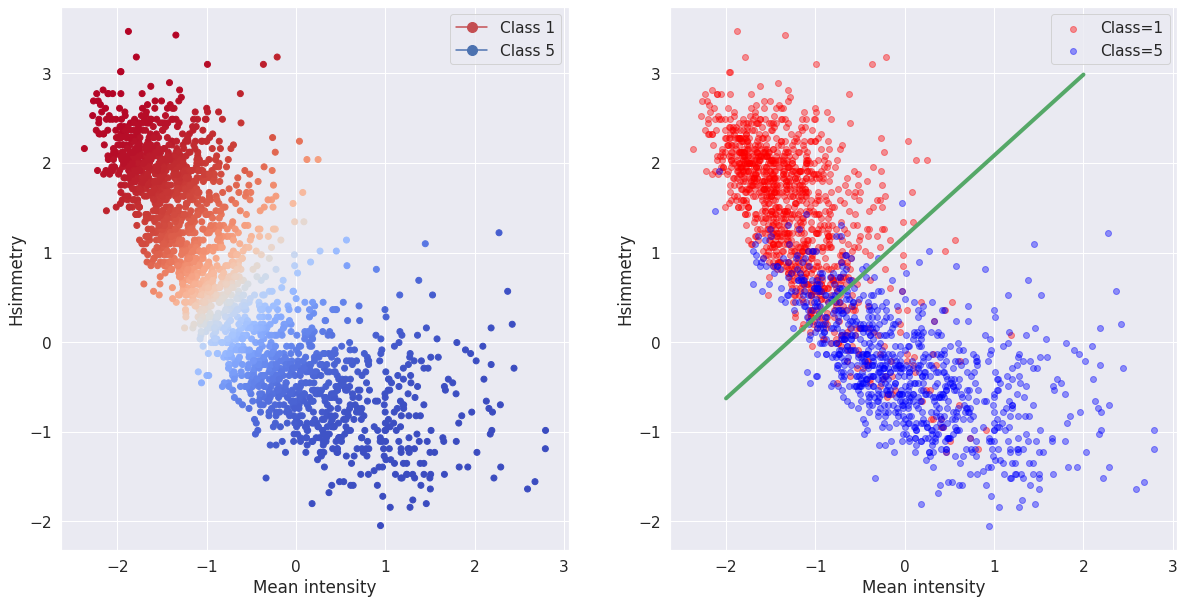

In [66]:
from matplotlib.lines import Line2D

y_pred = predict_logistic(X_test, w_logistic)

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)

ax1.scatter(x = X_test[:,0], y = X_test[:,1],\
            c = -y_pred, cmap = 'coolwarm')
legend_elements = [Line2D([0], [0], marker='o', color='r',\
                    label='Class %d'%N, markerfacecolor='r',\
                    markersize=10),\
Line2D([0], [0], marker='o', color='b',\
                    label='Class %d'%P, markerfacecolor='b',\
                    markersize=10)]
ax1.set_xlabel(F[0])
ax1.set_ylabel(F[1])
ax1.legend(handles=legend_elements, loc='best')
      
ax2 = fig.add_subplot(122)
plot_features(ax2,X_test,y_test)

p1 = (-2, -(w_logistic[0] - 2*w_logistic[1])/w_logistic[2])
p2 = (2,  -(w_logistic[0] + 2*w_logistic[1])/w_logistic[2])

lines = ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], '-')
plt.setp(lines, color='g', linewidth=4.0)

plt.show()


TP =  759    FP =  107
FN =  133    TN = 1028
Accuracy = 1787 / 2027 (0.881598)



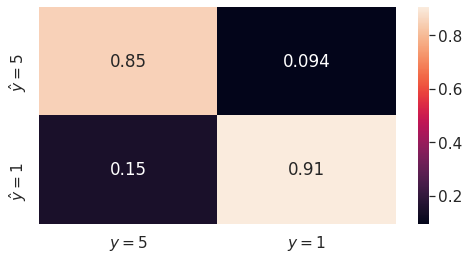

In [67]:
p_hat = predict_logistic(X_test, w_logistic)
y_hat = np.where(p_hat >= best, 1, -1)
plot_confusion_matrix(y_test, y_hat)

### <font style="background-color: #ffff66;">Exercise 8</font>
<font style="background-color: #ffff66;">If you got to this point, make a copy of your notebook.
Run the <i>copy notebook</i> changing the number of positive and negative examples. Try an unbalanced training set and observe if there are any effects in the accuracy on the test set. Additionaly, you may try with a different pair of classes. Summarize HERE the experiments you did and comment whatever you found interesting. There is no need to submit the <i>copy notebook</i>.</font>

When data has unbalanced samples with 10x more positive cases than negative ones, Ein decreases, as the higher number of positive cases decreases the cross-entropy in data. In this scenario, Accuracy decreases to 0.7163.
When the number of negative cases are 10x higher than positive cases, Ein goes to the same number as previous case (~0.18), with Accuracy also decreases, to 0.76.

[1]: François Chollet and others, Keras, https://keras.io, 2015

[2]: Yaser S Abu-Mostafa, Malik Magdon-Ismail, and Hsuan-Tien Lin, _Learning from Data_, 2012